In [1]:
from keras.applications import VGG16
vgg_base=VGG16(weights='imagenet',include_top=False, input_shape=(150,150,3))
vgg_base.summary()

Using TensorFlow backend.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator
base_dir='C:/Users/ysp/Desktop/Deep Learning/dogs and cats_small'#여기부터~
train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'validation')
test_dir=os.path.join(base_dir,'test')  #여기까지 아래 프로그램 작성을 위해 5.2절에서 만든 path만 지정

import numpy as np
imagegen=ImageDataGenerator(rescale=1./255)
batch=20
def extract_features(directory,sample):
    features=np.zeros(shape=(sample,4,4,512))
    labels=np.zeros(shape=(sample))
    generator=imagegen.flow_from_directory(directory,target_size=(150,150), batch_size=batch, class_mode='binary')
    i=0
    for batched_input, batched_label in generator:
        batched_features=vgg_base.predict(batched_input)
        features[i*batch:(i+1)*batch]=batched_features
        labels[i*batch:(i+1)*batch]=batched_label
        i+=1
        if i*batch>=sample:
            break
    return features, labels

train_input, train_labels=extract_features(train_dir,2000)
validation_input, validation_labels=extract_features(validation_dir,1000)
test_input, test_labels=extract_features(test_dir,1000)
train_input.shape

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


(2000, 4, 4, 512)

In [3]:
train_features=np.reshape(train_input, (2000,4*4*512))
validation_features=np.reshape(validation_input, (1000,4*4*512))
test_features=np.reshape(test_input, (1000,4*4*512))

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers

model1=Sequential()
model1.add(Dense(256, activation='relu',input_dim=4*4*512))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
model1_result=model1.fit(train_features,train_labels, epochs=20,batch_size=20,validation_data=(validation_features,validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/20
2000/2000 [==============================] - 1s 664us/step - loss: 0.5968 - acc: 0.6770 - val_loss: 0.4515 - val_acc: 0.8200
Epoch 2/20
2000/2000 [==============================] - 1s 636us/step - loss: 0.4294 - acc: 0.8045 - val_loss: 0.3678 - val_acc: 0.8760
Epoch 3/20
2000/2000 [==============================] - 1s 607us/step - loss: 0.3583 - acc: 0.8545 - val_loss: 0.3283 - val_acc: 0.8820
Epoch 4/20
2000/2000 [==============================] - 1s 631us/step - loss: 0.3137 - acc: 0.8780 - val_loss: 0.3074 - val_acc: 0.8800
Epoch 5/20
2000/2000 [==============================] - 1s 624us/step - loss: 0.2953 - acc: 0.8775 - val_loss: 0.2889 - val_acc: 0.8910
Epoch 6/20
2000/2000 [==============================] - 1s 618us/step - loss: 0.2624 - acc: 0.8995 - val_loss: 0.2779 - val_acc: 0.8910
Epoch 7/20
2000/2000 [==============================] - 1s 617us/step - loss: 0.2576 - acc: 0.8965 - val_loss: 0.2697 - val_acc: 0.8910


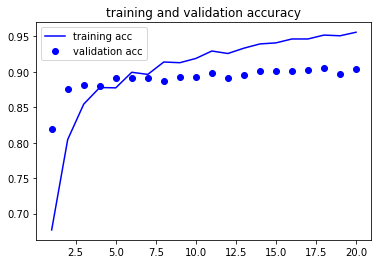

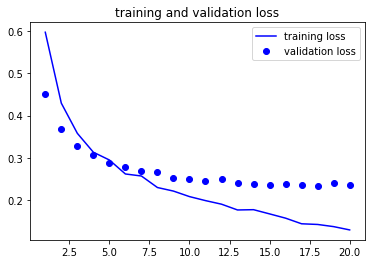

In [15]:
import matplotlib.pyplot as plt
acc=model1_result.history['acc']
val_acc=model1_result.history['val_acc']
loss=model1_result.history['loss']
val_loss=model1_result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model_aug=Sequential()
model_aug.add(vgg_base)
model_aug.add(Flatten())
model_aug.add(Dense(256,activation='relu'))
model_aug.add(Dense(1,activation='sigmoid'))
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [17]:
print(len(model_aug.trainable_weights))

30


In [8]:
vgg_base.trainable=False
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=40, width_shift_range=0.2,
                               height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                horizontal_flip=True, fill_mode='nearest')
validation_datagen=ImageDataGenerator(rescale=1./255) #검증데이터는 자료증대를 하지 않아야 함.
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(150,150),
                                              batch_size=20, class_mode='binary')
validation_generator=train_datagen.flow_from_directory(validation_dir,target_size=(150,150),
                                              batch_size=20, class_mode='binary')

model_aug.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
model_aug_result=model_aug.fit_generator(train_generator,steps_per_epoch=200, epochs=20, validation_data=validation_generator,validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
200/200 [==============================] - 127s 633ms/step - loss: 0.5315 - acc: 0.7490 - val_loss: 0.5341 - val_acc: 0.7860
Epoch 2/20
200/200 [==============================] - 129s 646ms/step - loss: 0.4188 - acc: 0.8175 - val_loss: 0.4464 - val_acc: 0.8320
Epoch 3/20
200/200 [==============================] - 131s 656ms/step - loss: 0.3796 - acc: 0.8335 - val_loss: 0.3386 - val_acc: 0.8080
Epoch 4/20
200/200 [==============================] - 131s 653ms/step - loss: 0.3547 - acc: 0.8413 - val_loss: 0.1867 - val_acc: 0.8340
Epoch 5/20
200/200 [==============================] - 130s 648ms/step - loss: 0.3387 - acc: 0.8512 - val_loss: 0.2680 - val_acc: 0.8560
Epoch 6/20
200/200 [==============================] - 130s 649ms/step - loss: 0.3191 - acc: 0.8560 - val_loss: 0.2635 - val_acc: 0.8530
Epoch 7/20
200/200 [==============================] - 130s 650ms/step - loss: 0.3260 - acc: 0.8562 -

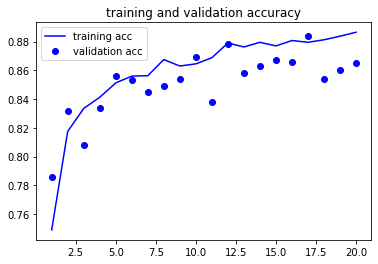

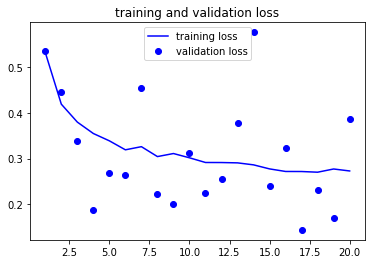

In [10]:
import matplotlib.pyplot as plt
acc=model_aug_result.history['acc']
val_acc=model_aug_result.history['val_acc']
loss=model_aug_result.history['loss']
val_loss=model_aug_result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [11]:
vgg_base.trainable=True
trainable_layer=False
for layer in vgg_base.layers:
    if layer.name=='block5_conv1': # block5_conv1부터 trainable_layer가 True로 layer.trainable이 True로 바뀜
        trainable_layer=True
    if trainable_layer:
        layer.trainable=True
    else:
        layer.trainable=False

In [12]:
from keras import optimizers
model_aug.compile(optimizer=optimizers.RMSprop(lr=1e-5),loss='binary_crossentropy',metrics=['acc'])
result_final=model_aug.fit_generator(train_generator,steps_per_epoch=200, epochs=30, validation_data=validation_generator,validation_steps=50)

Epoch 1/30
200/200 [==============================] - 160s 798ms/step - loss: 0.2768 - acc: 0.8783 - val_loss: 0.5292 - val_acc: 0.8640
Epoch 2/30
200/200 [==============================] - 162s 808ms/step - loss: 0.2303 - acc: 0.9015 - val_loss: 0.1380 - val_acc: 0.8590
Epoch 3/30
200/200 [==============================] - 162s 811ms/step - loss: 0.1899 - acc: 0.9237 - val_loss: 0.3999 - val_acc: 0.8920
Epoch 4/30
200/200 [==============================] - 162s 809ms/step - loss: 0.1795 - acc: 0.9270 - val_loss: 0.6132 - val_acc: 0.8870
Epoch 5/30
200/200 [==============================] - 162s 809ms/step - loss: 0.1552 - acc: 0.9390 - val_loss: 0.1284 - val_acc: 0.8940
Epoch 6/30
200/200 [==============================] - 162s 808ms/step - loss: 0.1416 - acc: 0.9370 - val_loss: 0.3602 - val_acc: 0.9030
Epoch 7/30
200/200 [==============================] - 162s 810ms/step - loss: 0.1266 - acc: 0.9492 - val_loss: 0.0111 - val_acc: 0.8960
Epoch 8/30
200/200 [============================

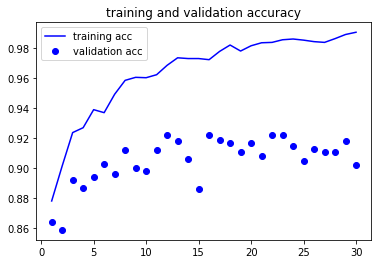

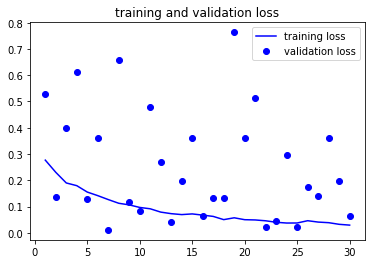

In [13]:
import matplotlib.pyplot as plt
acc=result_final.history['acc']
val_acc=result_final.history['val_acc']
loss=result_final.history['loss']
val_loss=result_final.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [14]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(test_dir,target_size=(150,150),
                                              batch_size=20, class_mode='binary')
loss, acc=model_aug.evaluate_generator(test_generator,steps=50)
print(loss)
print(acc)

Found 1000 images belonging to 2 classes.
0.028220493346452713
0.9290000200271606
